# Task 1

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats as smstats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats

In [2]:
# apikey = UP3EYYQQF45BSJL7
url_aapl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AAPL&outputsize=full&datatype=json&apikey=UP3EYYQQF45BSJL7'
url_googl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=GOOGL&outputsize=full&datatype=json&apikey=KKW8PLABFIOR8FWX'
url_fb = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=FB&outputsize=full&datatype=json&apikey=9FJH86DPVIOL3UWJ'

In [3]:
def stock_close_10(url, ticker):
    r = requests.get(url)
    
    # retrieving pandas dataframes
    data = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'], orient='index')
    
    # dropping the rest of the columns (we are using 'adjusted close' values only)
    close = data['5. adjusted close']
    
    # dropping data past last 10 years, renaming columns, typecasting
    close_10 = close.loc['2021-06-18':'2011-06-17'].to_frame().rename(columns={"5. adjusted close": ticker}).astype('d')
    return close_10

In [4]:
aapl_close_10 = stock_close_10(url_aapl, "AAPL")
googl_close_10 = stock_close_10(url_googl, "GOOGL")
fb_close_10 = stock_close_10(url_fb, "FB")

In [5]:
# concatenating into one DataFrame
daily_close = pd.concat([aapl_close_10, googl_close_10, fb_close_10], axis=1, sort=False)
daily_close.index = pd.to_datetime(daily_close.index)

daily_close.head()

,AAPL,GOOGL,FB
2021-06-18,130.46,2402.22,329.66
2021-06-17,131.79,2434.87,336.51
2021-06-16,130.15,2415.45,331.08
2021-06-15,129.64,2428.39,336.75
2021-06-14,130.48,2448.91,336.77


In [6]:
# basic descriptive statistics
daily_close.describe()

,AAPL,GOOGL,FB
count,2518.000000,2518.000000,2286.000000
mean,39.843032,859.003728,132.679271
std,31.221999,468.544339,76.161889
min,9.682574,238.175224,17.729000
25%,18.589870,519.278332,74.142500
50%,27.522508,766.510000,127.940000
75%,46.418776,1140.652500,181.752500
max,142.704617,2448.910000,336.770000


In [7]:
# setting plots parameters, seed
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8)
np.random.seed(9)

C:\Users\ivank\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


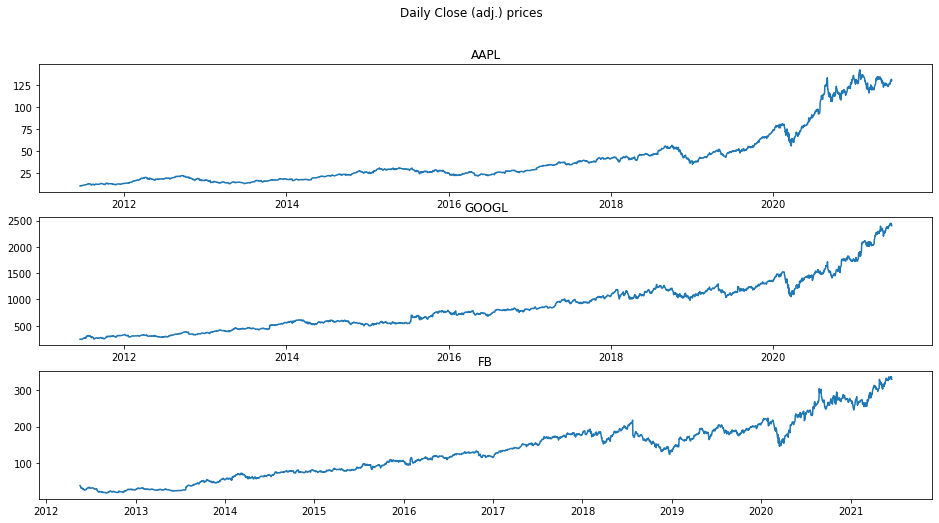

In [8]:
# we should plot daily prices now
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Daily Close (adj.) prices')
ax1.plot(daily_close.AAPL)
ax1.set_title('AAPL')
ax2.plot(daily_close.GOOGL)
ax2.set_title('GOOGL')
ax3.plot(daily_close.FB)
ax3.set_title('FB')

plt.show()

# Task 2

In [9]:
# obtaining returns
daily_returns = - daily_close.diff(1) / daily_close

daily_returns.head()

,AAPL,GOOGL,FB
2021-06-18,NaN,NaN,NaN
2021-06-17,-0.010092,-0.013409,-0.020356
2021-06-16,0.012601,0.008040,0.016401
2021-06-15,0.003934,-0.005329,-0.016837
2021-06-14,-0.006438,-0.008379,-0.000059


In [10]:
# descriptive analysis of returns

daily_returns.describe()

,AAPL,GOOGL,FB
count,2517.000000,2517.000000,2285.000000
mean,0.001192,0.001044,0.001214
std,0.018104,0.016389,0.023382
min,-0.128647,-0.116342,-0.189609
25%,-0.007137,-0.006419,-0.009438
50%,0.000893,0.000960,0.001056
75%,0.010454,0.009155,0.012337
max,0.119808,0.162584,0.296077


### AAPL

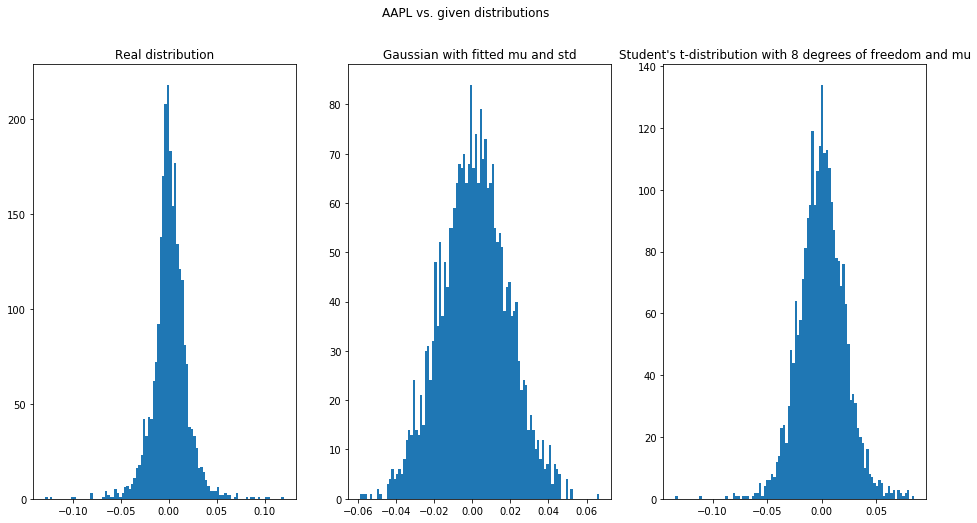

In [11]:
# let's start with visualizations

def returns_vs_plots(daily_returns, ticker, df=4, plot=True):
    np.random.seed(10)
    
    # retrieving count, mean and std of ticker
    n = daily_returns[ticker].describe().loc['count'].astype(int)
    mu = daily_returns[ticker].describe().loc['mean']
    std = daily_returns[ticker].describe().loc['std']
    
    # dropping NaNs = getting only first n instances
    returns = np.array(daily_returns[ticker])[1:(n+1)]
    
    # considering given distributions
    gaussian = np.random.normal(mu, std, n)
    student = (np.random.standard_t(df, n) + mu) * std
    
    if plot:
        # plotting returns vs these dists
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.suptitle(ticker + ' vs. given distributions')
        ax1.hist(returns, bins=100)
        ax1.set_title('Real distribution')
        ax2.hist(gaussian, bins=100)
        ax2.set_title('Gaussian with fitted mu and std')
        ax3.hist(student, bins=100)
        ax3.set_title("Student's t-distribution with " + str(df) + " degrees of freedom and mu")

        plt.show()
    
    return n, mu, std, returns, gaussian, student

# firstly, we will consider AAPL vs given dists
n_aapl, mu_aapl, std_aapl, returns_aapl, gaussian_aapl, student_aapl = returns_vs_plots(daily_returns, 'AAPL', 8)

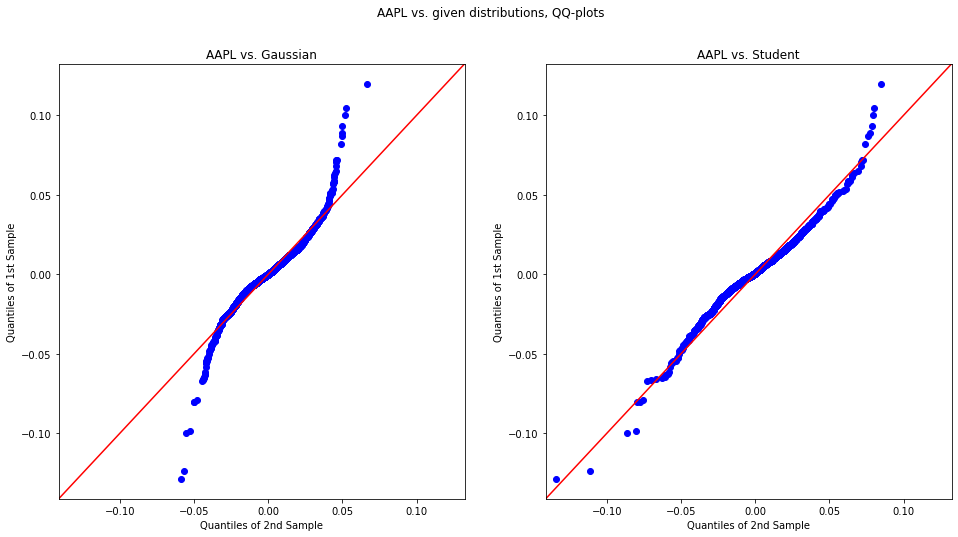

In [12]:
# let's move on to qqplots

def qqplots(daily_returns, ticker, df=4):
    
    _, _, _, returns, gaussian, student = returns_vs_plots(daily_returns, ticker, df=df, plot=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(ticker + ' vs. given distributions, QQ-plots')
    ax1.set_title(ticker + ' vs. Gaussian')
    ax2.set_title(ticker + ' vs. Student')
    sm.qqplot(returns, other=gaussian, line='45', ax=ax1)
    sm.qqplot(returns, other=student, line='45', ax=ax2)
    
    plt.show()
    
qqplots(daily_returns, 'AAPL', 8)

# qqplot for gaussian is not very close to a line => doesn't look like gaussian
# for student it's much closer

In [13]:
# finally, let's run some goodness of fit tests

def goodness_of_fit_tests(daily_returns, ticker, df=8):
    _, _, _, returns, _, _ = returns_vs_plots(daily_returns, ticker, plot=False)
    
    # Lilliefors’ tests
    ks_norm = smstats.diagnostic.kstest_normal(returns)
    ks_exp = smstats.diagnostic.kstest_exponential(returns)
    loc, scale = stats.t.fit_loc_scale(returns, df)
    ks_t = stats.kstest(returns, 't', args=(df, loc, scale))
    
    return pd.DataFrame([ks_norm, ks_exp, ks_t], index=['Lilliefors_norm', 'Lilliefors_exp', 'Lilliefors_t'], columns=['statistic', 'pvalue'])

goodness_of_fit_tests(daily_returns, 'AAPL')

# pvalues are smaller than 0.05 => rejecting all null hypotheses (that returns are normally, exponentially or student distributed) at 0.05 level

,statistic,pvalue
Lilliefors_norm,0.077694,2.441853e-40
Lilliefors_exp,0.473182,1.000000e-02
Lilliefors_t,0.058379,6.730882e-08


Results of ADF Test:
Test Statistic         -1.000252e+01
p-value                 1.867949e-17
Lags Used               2.100000e+01
Critical Value (1%)    -3.432974e+00
Critical Value (5%)    -2.862699e+00
Critical Value (10%)   -2.567387e+00
dtype: float64


Results of KPSS Test:
Test Statistic           0.120208
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\ivank\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


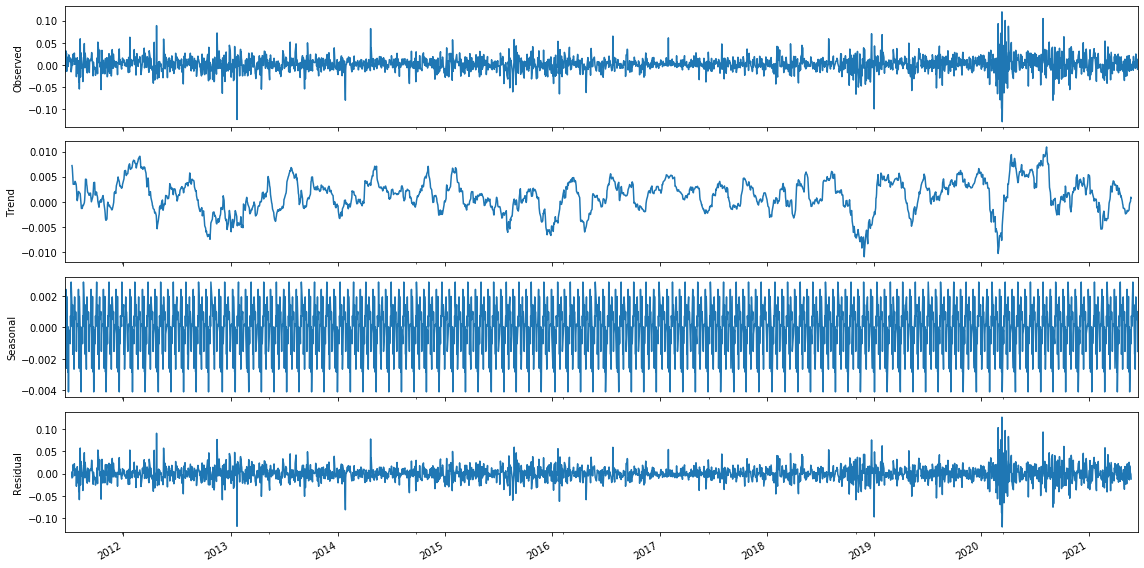

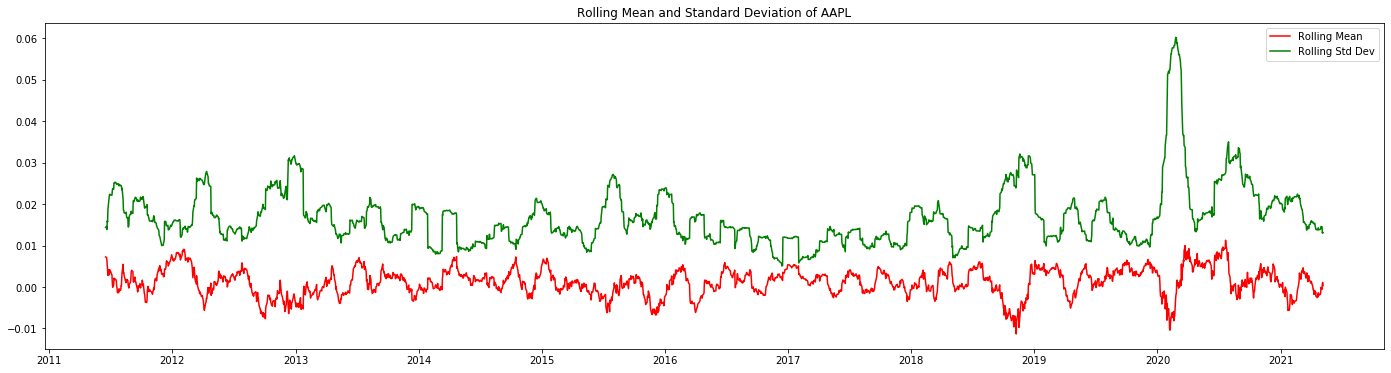

In [14]:
# moving on to a stationary analysis of returns

def stationary_analysis(daily_returns, ticker):
    returns = daily_returns[ticker].dropna()
    
    
    print('Results of ADF Test:')
    adftest = adfuller(returns)   
    adf_output = pd.Series(adftest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in adftest[4].items():
        adf_output['Critical Value (%s)' %key] = value
    print (adf_output)    
        
    print('\n')
    
    print ('Results of KPSS Test:')
    kpsstest = kpss(returns, regression='c', lags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' %key] = value
    print (kpss_output)
    
    decomposition = seasonal_decompose(returns.to_frame(), freq=30)
    decomposition.plot()
    
    # calculating rolling mean and rolling standard deviation:
    rolling_mean = returns.rolling(30).mean()
    rolling_std_dev = returns.rolling(30).std()
    
    plt.figure(figsize=(24, 6))
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='green', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of ' + ticker)
    
    
    plt.show()
    
stationary_analysis(daily_returns, 'AAPL')

# rolling mean and std are changing in time => there is a possibility that our data is not stationary
# pvalue for ADF test is almost 0, so we reject the null hypothesis that the data is not stationary => AAPL returns are stationary
# pvalue for KPSS test is greater than 0.05 => can't reject the null hypothesis that the data is stationary on 0.05 significance level

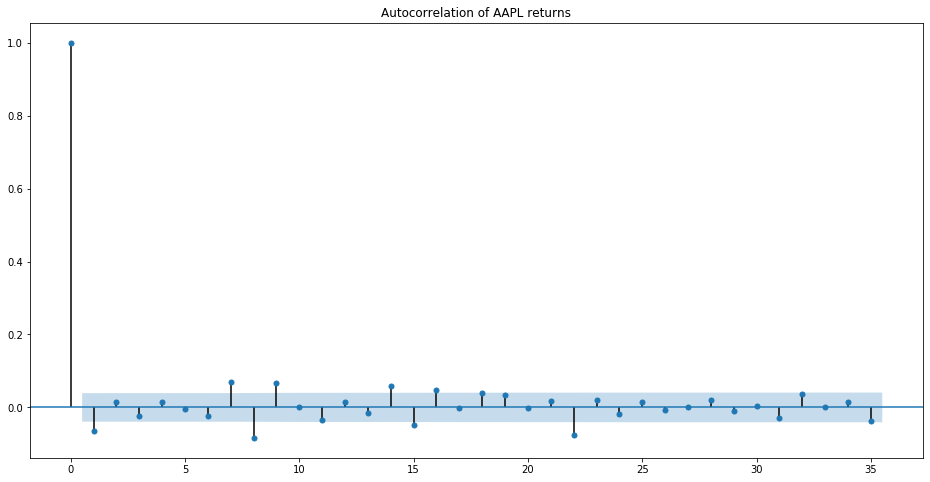

In [15]:
# to see if there is any dependency of time series values to their previous values, we will use autocorrelation function

plot_acf(returns_aapl, title='Autocorrelation of AAPL returns')
plt.show()

# as values of acf are close to zero, there is probably no dependency in our data

### GOOGL

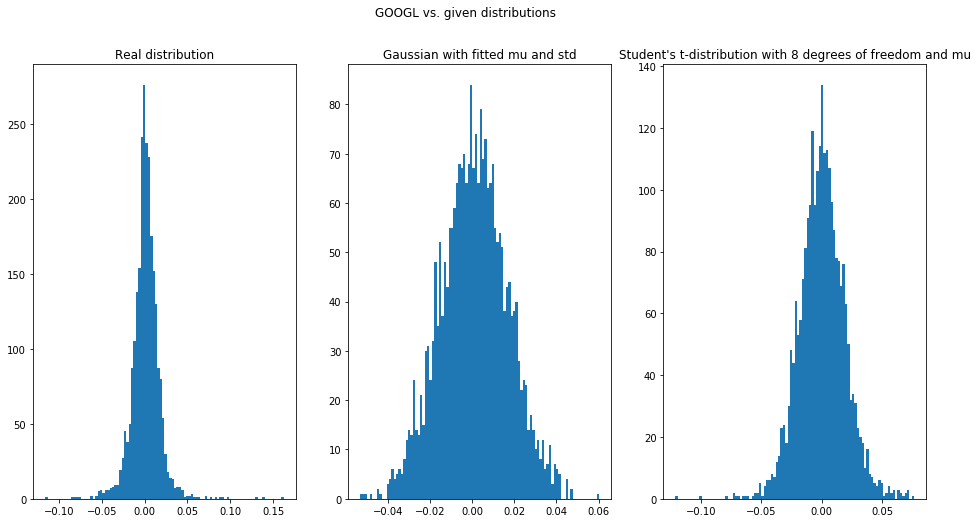

In [16]:
n_googl, mu_googl, std_googl, returns_googl, _, _ = returns_vs_plots(daily_returns, 'GOOGL', 8)

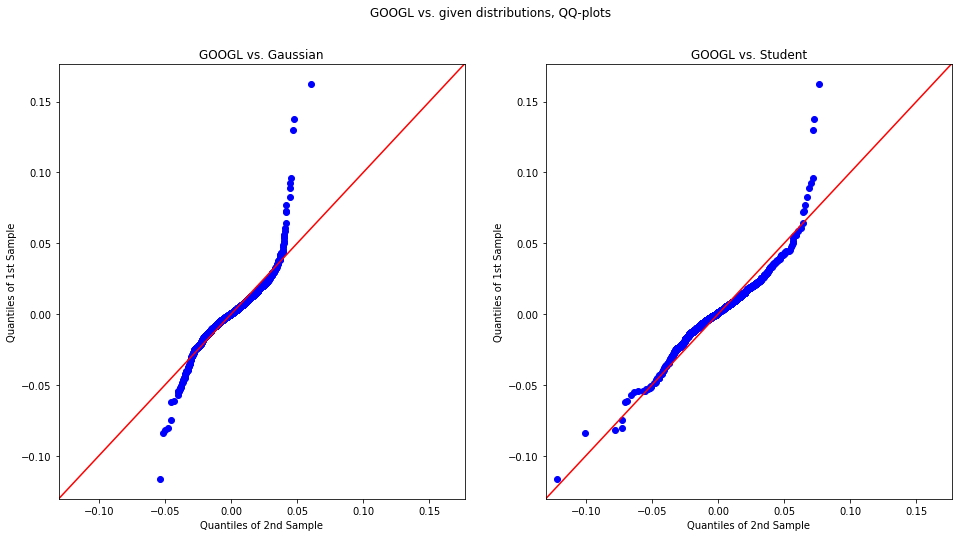

In [17]:
qqplots(daily_returns, 'GOOGL', 8)

# qqplots are not very close to a line => doesn't look like gaussian or student

In [18]:
goodness_of_fit_tests(daily_returns, 'GOOGL', 8)

# pvalues are smaller than 0.05 => rejecting all null hypotheses (that returns are normally, exponentially or student distributed) at 0.05 level

,statistic,pvalue
Lilliefors_norm,0.075976,1.690778e-38
Lilliefors_exp,0.467620,1.000000e-02
Lilliefors_t,0.058886,4.986855e-08


Results of ADF Test:
Test Statistic         -1.713705e+01
p-value                 7.086136e-30
Lags Used               8.000000e+00
Critical Value (1%)    -3.432960e+00
Critical Value (5%)    -2.862693e+00
Critical Value (10%)   -2.567384e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.049685
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\ivank\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


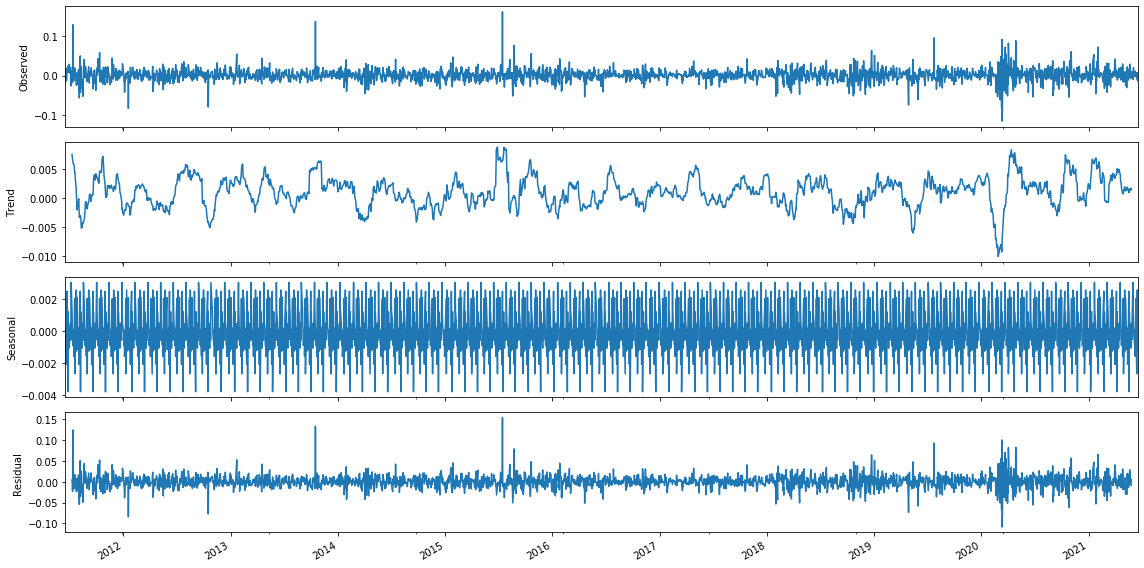

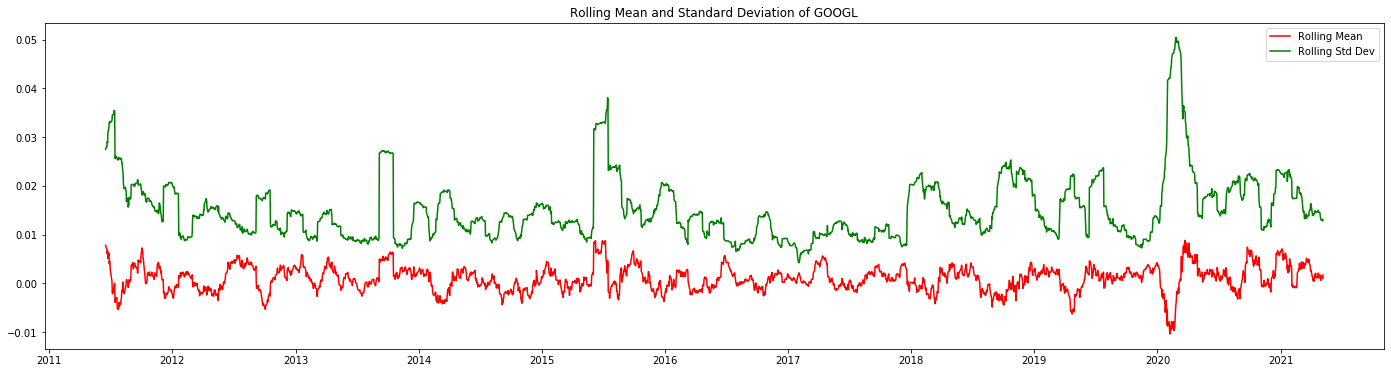

In [19]:
stationary_analysis(daily_returns, 'GOOGL')

# rolling mean and std are changing in time => there is a possibility that our data is not stationary
# pvalue for ADF test is almost 0, so we reject the null hypothesis that the data is not stationary => AAPL returns are stationary
# pvalue for KPSS test is greater than 0.05 => can't reject the null hypothesis that the data is stationary on 0.05 significance level

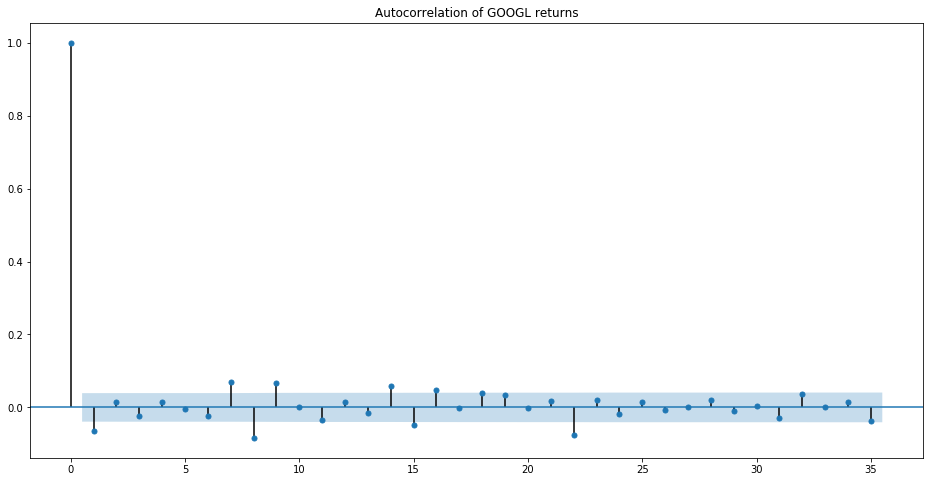

In [20]:
plot_acf(returns_aapl, title='Autocorrelation of GOOGL returns')
plt.show()

# as values of acf are close to zero, there is probably no dependency in our data

### FB

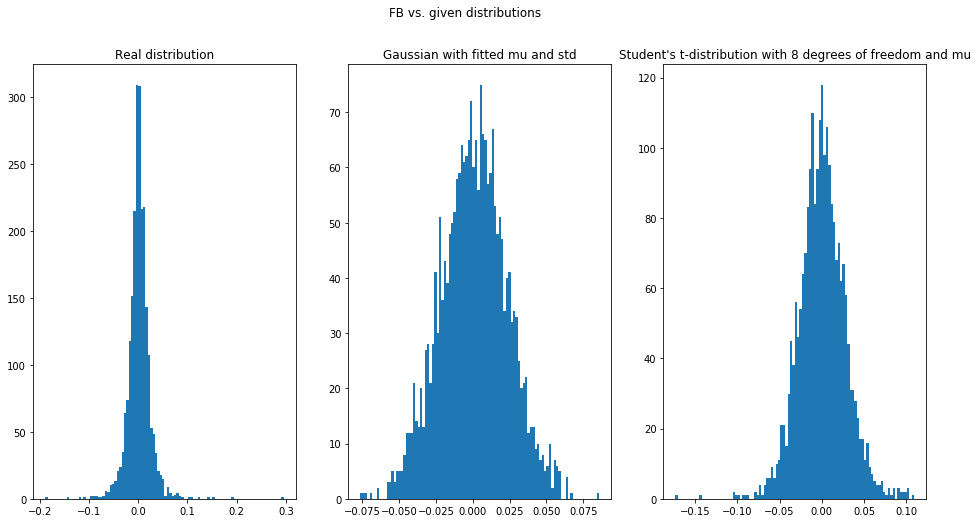

In [21]:
n_fb, mu_fb, std_fb, returns_fb, _, _ = returns_vs_plots(daily_returns, 'FB', 8)

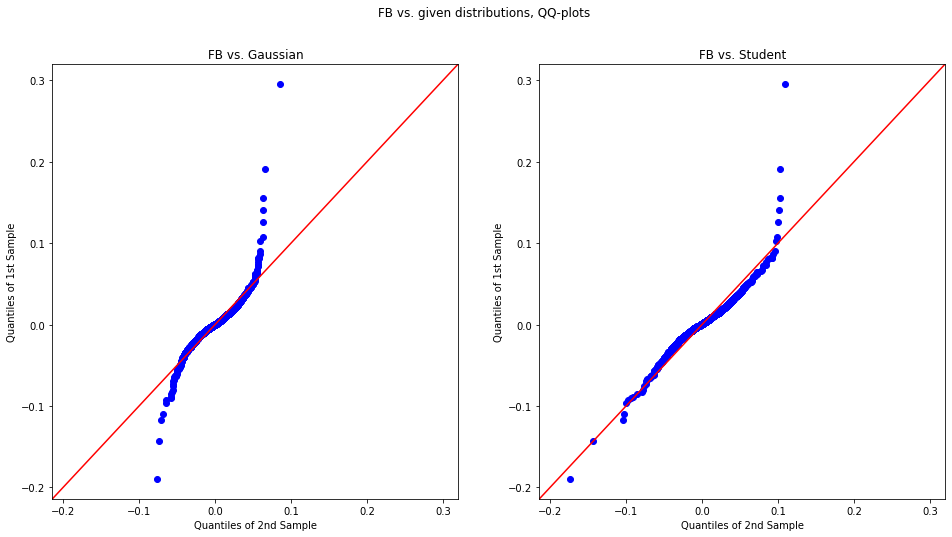

In [22]:
qqplots(daily_returns, 'FB', 8)

# qqplots are not very close to a line => doesn't look like gaussian or student

In [23]:
goodness_of_fit_tests(daily_returns, 'FB', 8)

# pvalues are smaller than 0.05 => rejecting all null hypotheses (that returns are normally, exponentially or student distributed) at 0.05 level

,statistic,pvalue
Lilliefors_norm,0.084610,1.174451e-43
Lilliefors_exp,0.473961,1.000000e-02
Lilliefors_t,0.064811,8.678104e-09


Results of ADF Test:
Test Statistic         -1.545760e+01
p-value                 2.732272e-28
Lags Used               9.000000e+00
Critical Value (1%)    -3.433228e+00
Critical Value (5%)    -2.862811e+00
Critical Value (10%)   -2.567447e+00
dtype: float64


Results of KPSS Test:
Test Statistic           0.053097
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\ivank\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


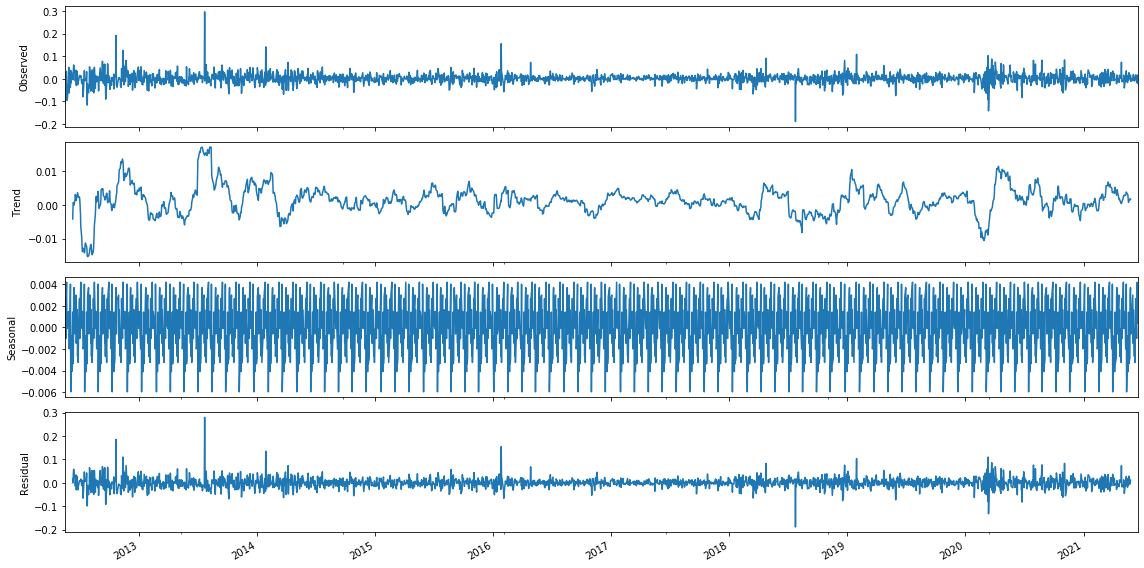

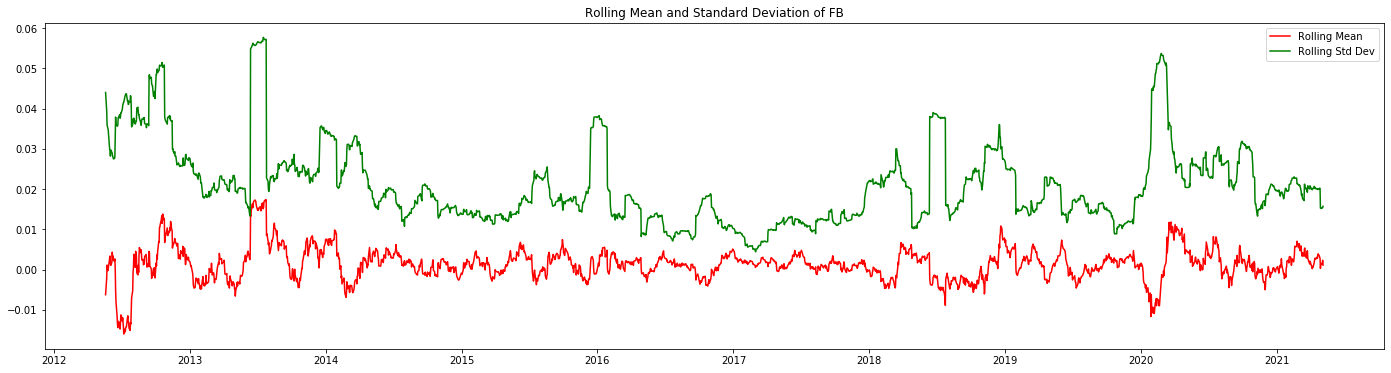

In [24]:
stationary_analysis(daily_returns, 'FB')

# rolling mean and std are changing in time => there is possibility that our data is not stationary
# pvalue for ADF test is almost 0, so we reject the null hypothesis that the data is not stationary => AAPL returns are stationary
# pvalue for KPSS test is greater than 0.05 => can't reject the null hypothesis that the data is stationary on 0.05 significance level

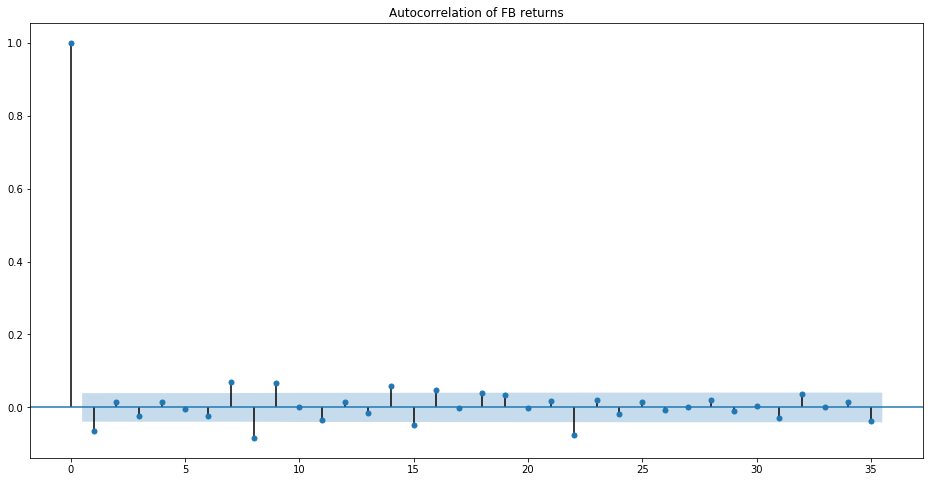

In [25]:
plot_acf(returns_aapl, title='Autocorrelation of FB returns')
plt.show()

# as values of acf are close to zero, there is probably no dependency in our data

In [26]:
# Granger Causality tests

grangercausalitytests(daily_returns.drop('FB', axis=1).dropna(), 4)
# we can reject the null hypothesis (that GOOGL Granger cause AAPL) in the first 3 cases (when lag is up to 3)
# at the 0.05 significance level
# in the last case (lag is 4) we can't reject


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6219  , p=0.0058  , df_denom=2513, df_num=1
ssr based chi2 test:   chi2=7.6310  , p=0.0057  , df=1
likelihood ratio test: chi2=7.6194  , p=0.0058  , df=1
parameter F test:         F=7.6219  , p=0.0058  , df_denom=2513, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0126  , p=0.0182  , df_denom=2510, df_num=2
ssr based chi2 test:   chi2=8.0413  , p=0.0179  , df=2
likelihood ratio test: chi2=8.0284  , p=0.0181  , df=2
parameter F test:         F=4.0126  , p=0.0182  , df_denom=2510, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9573  , p=0.0312  , df_denom=2507, df_num=3
ssr based chi2 test:   chi2=8.8967  , p=0.0307  , df=3
likelihood ratio test: chi2=8.8809  , p=0.0309  , df=3
parameter F test:         F=2.9573  , p=0.0312  , df_denom=2507, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3097  , p=0.

{1: ({'ssr_ftest': (7.621899996394196, 0.0058082480167065955, 2513.0, 1),
   'ssr_chi2test': (7.630998961769915, 0.005737351627820238, 1),
   'lrtest': (7.619449942019855, 0.00577420975085056, 1),
   'params_ftest': (7.62189999639482, 0.005808248016705533, 2513.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.012645521880317, 0.018201627011723745, 2510.0, 2),
   'ssr_chi2test': (8.041277679305974, 0.017941499536277855, 2),
   'lrtest': (8.028449717934564, 0.018056945807071862, 2),
   'params_ftest': (4.012645521880243, 0.018201627011726056, 2510.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.9572941399697483, 0.031239849557363242, 2507.0, 3),
   'ssr_chi2test': (8.89665432933859, 0.03069695231687758, 3),
   'lrtest': (8.880949433078058, 0.030916328157412295, 3),
   'params_ftest': (2.9572941399697066, 0.031239849557363242, 2507.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
      

In [27]:
# reorder columns (exploring AAPL vs. GOOGL)
perm = daily_returns.drop('FB', axis=1).dropna()
cols = perm.columns.tolist()
cols = cols[::-1]
perm = perm[cols]
grangercausalitytests(perm, 4)
# for lag 1 we can reject the null hypothesis (so, AAPL Granger cause GOOGL)
# for the rest of lags we can't reject


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5493  , p=0.0330  , df_denom=2513, df_num=1
ssr based chi2 test:   chi2=4.5548  , p=0.0328  , df=1
likelihood ratio test: chi2=4.5507  , p=0.0329  , df=1
parameter F test:         F=4.5493  , p=0.0330  , df_denom=2513, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1742  , p=0.1139  , df_denom=2510, df_num=2
ssr based chi2 test:   chi2=4.3571  , p=0.1132  , df=2
likelihood ratio test: chi2=4.3533  , p=0.1134  , df=2
parameter F test:         F=2.1742  , p=0.1139  , df_denom=2510, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4798  , p=0.2180  , df_denom=2507, df_num=3
ssr based chi2 test:   chi2=4.4518  , p=0.2166  , df=3
likelihood ratio test: chi2=4.4478  , p=0.2170  , df=3
parameter F test:         F=1.4798  , p=0.2180  , df_denom=2507, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2984  , p=0.

{1: ({'ssr_ftest': (4.549349801488587, 0.03302789250128606, 2513.0, 1),
   'ssr_chi2test': (4.554780780161276, 0.03282696594684915, 1),
   'lrtest': (4.550662929639657, 0.0329060036327387, 1),
   'params_ftest': (4.549349801488245, 0.03302789250128606, 2513.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.1741993306085483, 0.11391323929680498, 2510.0, 2),
   'ssr_chi2test': (4.357060809944621, 0.11320777804005688, 2),
   'lrtest': (4.353291012379486, 0.11342136447423003, 2),
   'params_ftest': (2.1741993306086567, 0.11391323929680498, 2510.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.479795436058971, 0.21803896306602044, 2507.0, 3),
   'ssr_chi2test': (4.451781882232453, 0.2166317692285818, 3),
   'lrtest': (4.447844929811254, 0.21698984625913, 3),
   'params_ftest': (1.479795436058912, 0.21803896306602044, 2507.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

In [28]:
grangercausalitytests(daily_returns.drop('AAPL', axis=1).dropna(), 4)
# we can't reject here for any of the lags (H0: FB does not Granger cause GOOGL) at 0.05 level


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9103  , p=0.1671  , df_denom=2281, df_num=1
ssr based chi2 test:   chi2=1.9128  , p=0.1667  , df=1
likelihood ratio test: chi2=1.9120  , p=0.1667  , df=1
parameter F test:         F=1.9103  , p=0.1671  , df_denom=2281, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9517  , p=0.3862  , df_denom=2278, df_num=2
ssr based chi2 test:   chi2=1.9076  , p=0.3853  , df=2
likelihood ratio test: chi2=1.9068  , p=0.3854  , df=2
parameter F test:         F=0.9517  , p=0.3862  , df_denom=2278, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2115  , p=0.3040  , df_denom=2275, df_num=3
ssr based chi2 test:   chi2=3.6457  , p=0.3023  , df=3
likelihood ratio test: chi2=3.6428  , p=0.3027  , df=3
parameter F test:         F=1.2115  , p=0.3040  , df_denom=2275, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5451  , p=0.

{1: ({'ssr_ftest': (1.9102984630922863, 0.16706543429270712, 2281.0, 1),
   'ssr_chi2test': (1.9128109117504524, 0.16665135207167622, 1),
   'lrtest': (1.9120103854693298, 0.16674011270572386, 1),
   'params_ftest': (1.9102984630918394, 0.16706543429273746, 2281.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9517003140309725, 0.38623745314297464, 2278.0, 2),
   'ssr_chi2test': (1.907578416973407, 0.38527835401609134, 2),
   'lrtest': (1.9067819146293914, 0.38543182212952715, 2),
   'params_ftest': (0.9517003140304967, 0.3862374531431212, 2278.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.2115189406880666, 0.30398514876324595, 2275.0, 3),
   'ssr_chi2test': (3.645740073824397, 0.30234619503951266, 3),
   'lrtest': (3.642830941196735, 0.3027044013687377, 3),
   'params_ftest': (1.2115189406882316, 0.30398514876323823, 2275.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          

In [29]:
perm = daily_returns.drop('AAPL', axis=1).dropna()
cols = perm.columns.tolist()
cols = cols[::-1]
perm = perm[cols]
grangercausalitytests(perm, 4)
# also can't reject


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6534  , p=0.4190  , df_denom=2281, df_num=1
ssr based chi2 test:   chi2=0.6542  , p=0.4186  , df=1
likelihood ratio test: chi2=0.6542  , p=0.4186  , df=1
parameter F test:         F=0.6534  , p=0.4190  , df_denom=2281, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3752  , p=0.6872  , df_denom=2278, df_num=2
ssr based chi2 test:   chi2=0.7521  , p=0.6866  , df=2
likelihood ratio test: chi2=0.7520  , p=0.6866  , df=2
parameter F test:         F=0.3752  , p=0.6872  , df_denom=2278, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2904  , p=0.8324  , df_denom=2275, df_num=3
ssr based chi2 test:   chi2=0.8738  , p=0.8317  , df=3
likelihood ratio test: chi2=0.8736  , p=0.8318  , df=3
parameter F test:         F=0.2904  , p=0.8324  , df_denom=2275, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5976  , p=0.

{1: ({'ssr_ftest': (0.6533898242890597, 0.41898762330273054, 2281.0, 1),
   'ssr_chi2test': (0.6542491708356916, 0.41859757422431876, 1),
   'lrtest': (0.6541554842624464, 0.4186308917811724, 1),
   'params_ftest': (0.6533898242886964, 0.4189876233028206, 2281.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.3752164957348747, 0.6871829590864234, 2278.0, 2),
   'ssr_chi2test': (0.7520801227065135, 0.686574827374651, 2),
   'lrtest': (0.7519562724373827, 0.6866173449296644, 2),
   'params_ftest': (0.37521649573493066, 0.6871829590862493, 2278.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.2903755040999366, 0.8323835202657773, 2275.0, 3),
   'ssr_chi2test': (0.8738069015684247, 0.831743758329123, 3),
   'lrtest': (0.8736396483582212, 0.8317840527465984, 3),
   'params_ftest': (0.2903755040997687, 0.8323835202658383, 2275.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

In [30]:
grangercausalitytests(daily_returns.drop('GOOGL', axis=1).dropna(), 4)
# can reject for lags 1 and 2 (FB Granger cause AAPL)
# can't reject for remaining lags 3 and 4 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1234  , p=0.0134  , df_denom=2281, df_num=1
ssr based chi2 test:   chi2=6.1315  , p=0.0133  , df=1
likelihood ratio test: chi2=6.1233  , p=0.0133  , df=1
parameter F test:         F=6.1234  , p=0.0134  , df_denom=2281, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1751  , p=0.0420  , df_denom=2278, df_num=2
ssr based chi2 test:   chi2=6.3641  , p=0.0415  , df=2
likelihood ratio test: chi2=6.3552  , p=0.0417  , df=2
parameter F test:         F=3.1751  , p=0.0420  , df_denom=2278, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1496  , p=0.0920  , df_denom=2275, df_num=3
ssr based chi2 test:   chi2=6.4687  , p=0.0909  , df=3
likelihood ratio test: chi2=6.4596  , p=0.0913  , df=3
parameter F test:         F=2.1496  , p=0.0920  , df_denom=2275, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6987  , p=0.

{1: ({'ssr_ftest': (6.1234133677737175, 0.013412522469043672, 2281.0, 1),
   'ssr_chi2test': (6.131466958349482, 0.013279664114227537, 1),
   'lrtest': (6.1232516038944595, 0.013341517142317856, 1),
   'params_ftest': (6.123413367774327, 0.013412522469035952, 2281.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.175078417046675, 0.041975834430101056, 2278.0, 2),
   'ssr_chi2test': (6.364094842947813, 0.04150059886059136, 2),
   'lrtest': (6.355241012071929, 0.041684725758771815, 2),
   'params_ftest': (3.1750784170467425, 0.041975834430101056, 2278.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.1496355015281097, 0.09201057260941513, 2275.0, 3),
   'ssr_chi2test': (6.468749293829204, 0.09090313558382018, 3),
   'lrtest': (6.459598152840044, 0.0912695432786065, 3),
   'params_ftest': (2.1496355015278463, 0.09201057260947118, 2275.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
      

In [31]:
perm = daily_returns.drop('GOOGL', axis=1).dropna()
cols = perm.columns.tolist()
cols = cols[::-1]
perm = perm[cols]
grangercausalitytests(perm, 4)
# the same applies for H0: AAPL does not Granger cause FB


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4051  , p=0.0114  , df_denom=2281, df_num=1
ssr based chi2 test:   chi2=6.4135  , p=0.0113  , df=1
likelihood ratio test: chi2=6.4045  , p=0.0114  , df=1
parameter F test:         F=6.4051  , p=0.0114  , df_denom=2281, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1075  , p=0.0449  , df_denom=2278, df_num=2
ssr based chi2 test:   chi2=6.2287  , p=0.0444  , df=2
likelihood ratio test: chi2=6.2202  , p=0.0446  , df=2
parameter F test:         F=3.1075  , p=0.0449  , df_denom=2278, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1009  , p=0.0981  , df_denom=2275, df_num=3
ssr based chi2 test:   chi2=6.3220  , p=0.0970  , df=3
likelihood ratio test: chi2=6.3133  , p=0.0973  , df=3
parameter F test:         F=2.1009  , p=0.0981  , df_denom=2275, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7577  , p=0.

{1: ({'ssr_ftest': (6.405095886435683, 0.011446039173991502, 2281.0, 1),
   'ssr_chi2test': (6.413519949416528, 0.011325468502565876, 1),
   'lrtest': (6.404532121490774, 0.011382941914826498, 1),
   'params_ftest': (6.405095886435204, 0.011446039173996331, 2281.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.1075045725887227, 0.04490198820702479, 2278.0, 2),
   'ssr_chi2test': (6.22865051731348, 0.0444084612655177, 2),
   'lrtest': (6.2201692060807545, 0.04459718212346407, 2),
   'params_ftest': (3.107504572588584, 0.04490198820703031, 2278.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.1008741055769167, 0.0980949232644994, 2275.0, 3),
   'ssr_chi2test': (6.322015000782229, 0.09695236297383603, 3),
   'lrtest': (6.31327393830361, 0.09732466297962386, 3),
   'params_ftest': (2.1008741055766613, 0.09809492326452897, 2275.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.

# Task 3

In [32]:
f_i = np.random.normal(size=n_aapl)
df_aapl = pd.DataFrame(f_i, index=daily_returns.index[1:], columns=['f_i'])

In [33]:
df_aapl = pd.concat([daily_returns['AAPL'].dropna(), df_aapl], axis=1, sort=False)
df_aapl['pnl_i'] = df_aapl['AAPL'] * df_aapl['f_i']
df_aapl

,AAPL,f_i,pnl_i
2021-06-17,-0.010092,-0.143440,0.001448
2021-06-16,0.012601,0.074152,0.000934
2021-06-15,0.003934,-0.057289,-0.000225
2021-06-14,-0.006438,1.140053,-0.007339
2021-06-11,0.024578,0.036616,0.000900
...,...,...,...
2011-06-23,-0.014733,0.393905,-0.005803
2011-06-22,0.026720,0.232473,0.006212
2011-06-21,-0.008269,-0.360481,0.002981
2011-06-20,0.031650,0.948532,0.030021


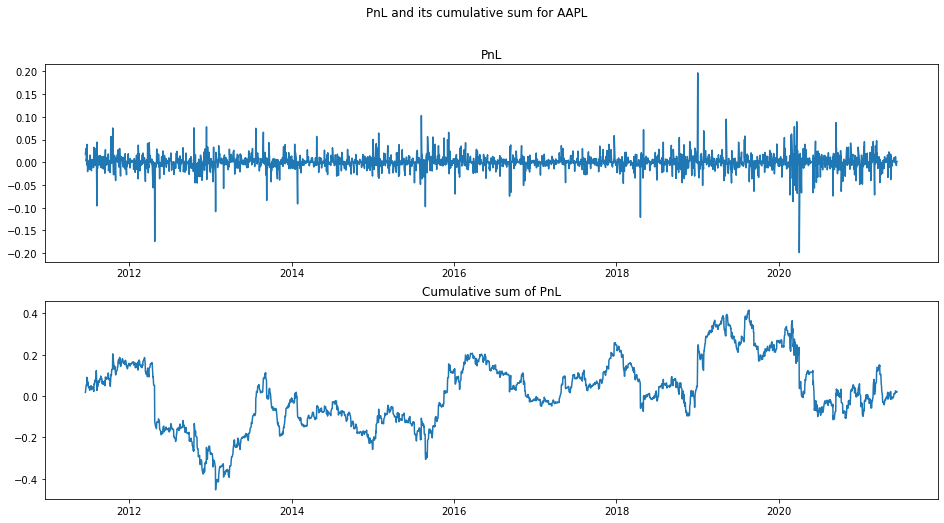

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('PnL and its cumulative sum for AAPL')
ax1.plot(df_aapl['pnl_i'])
ax1.set_title('PnL')
ax2.plot(df_aapl[::-1].cumsum()['pnl_i'])
ax2.set_title('Cumulative sum of PnL')

plt.show()

# Task 4

In [35]:
def df_builder():
    random_guess = np.random.normal(size=n_fb)
    df_fb = pd.DataFrame(random_guess, index=daily_returns.index[:n_fb], columns=['f_i'])
    df_fb = - df_fb.diff(1)
    df_fb = pd.concat([daily_returns['FB'], df_fb], axis=1, sort=False).dropna()
    df_fb['pnl_i'] = df_fb['FB'] * df_fb['f_i']
    
    return df_fb

In [36]:
df_fb = df_builder()
df_fb

,FB,f_i,pnl_i
2012-05-21,-0.089039,1.141441,-0.101633
2012-05-22,0.032258,-3.026996,-0.097645
2012-05-23,0.032188,3.023849,0.097330
2012-05-24,-0.033909,0.724169,-0.024556
2012-05-25,-0.096208,-0.286498,0.027563
...,...,...,...
2021-06-11,0.016633,-2.439737,-0.040581
2021-06-14,-0.000059,0.593323,-0.000035
2021-06-15,-0.016837,1.096352,-0.018460
2021-06-16,0.016401,-0.620327,-0.010174


In [37]:
def hit_rate(df_fb):
    hit_rate_df = df_fb[((df_fb['FB'] > 0) & (df_fb['f_i'] > 0)) | ((df_fb['FB'] < 0) & (df_fb['f_i'] < 0))]
    hit_rate = len(hit_rate_df) / len(df_fb)
    
    return hit_rate

In [38]:
hr = hit_rate(df_fb)
hr

0.5144483362521891

In [39]:
def sharpe_ratio(df_fb):
    return np.mean(df_fb['pnl_i']) / np.std(df_fb['pnl_i'])

In [40]:
sr = sharpe_ratio(df_fb)
sr

0.005554826115402042

In [41]:
df_list = [df_builder() for i in range(1000)]
hr_list = [hit_rate(df) for df in df_list]
sr_list = [sharpe_ratio(df) for df in df_list]

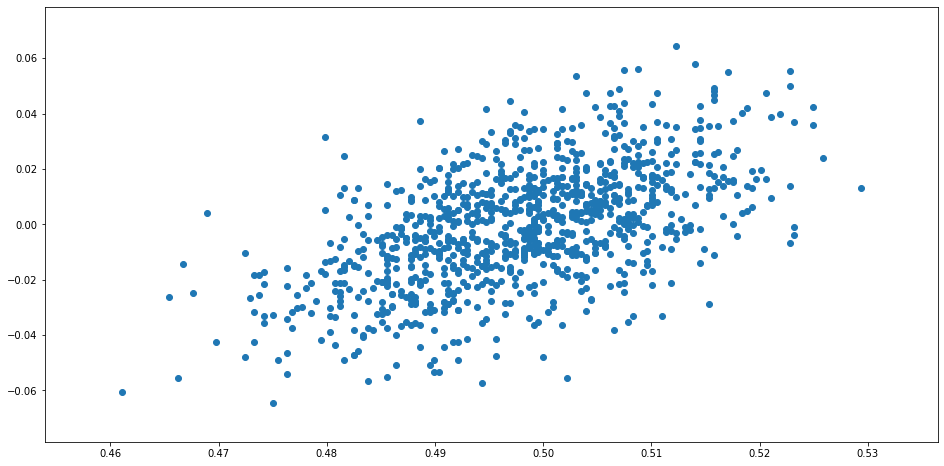

In [42]:
plt.scatter(hr_list, sr_list)
plt.show()

# Task 5

In [43]:
df = pd.read_csv('./xtask.csv')

In [44]:
df.head()

,a,b,c,d,class
0,-0.233408,-0.845698,0.365256,0.311292,1.0
1,0.073524,-0.747284,0.586381,0.303840,1.0
2,0.105561,-0.749805,0.149815,0.635771,1.0
3,-0.642419,-0.342424,-0.608454,0.229135,0.0
4,0.296581,-0.656553,0.022429,0.639708,0.0


In [45]:
df_train = df.dropna()
df_test = df[df['class'].isna()]

In [46]:
X_train = df_train.drop('class', axis=1)
y_train = df_train['class']

X_test = df_test.drop('class', axis=1)

In [47]:
X_train.describe()

# features' values are close to each other, means are close to 0 => no need in normalization

,a,b,c,d
count,3071.000000,3071.000000,3071.000000,3071.000000
mean,-0.002720,-0.000529,-0.004356,0.011408
std,0.492057,0.493647,0.487877,0.505907
min,-0.995371,-0.991212,-0.994118,-0.990012
25%,-0.399741,-0.404161,-0.398240,-0.389400
50%,-0.010718,-0.008298,-0.015014,0.001528
75%,0.398228,0.402412,0.381475,0.435223
max,0.995987,0.993865,0.983458,0.997183


In [48]:
y_train.value_counts()

# classes are a bit skewed towards positive ones

1.0    2026
0.0    1045
Name: class, dtype: int64

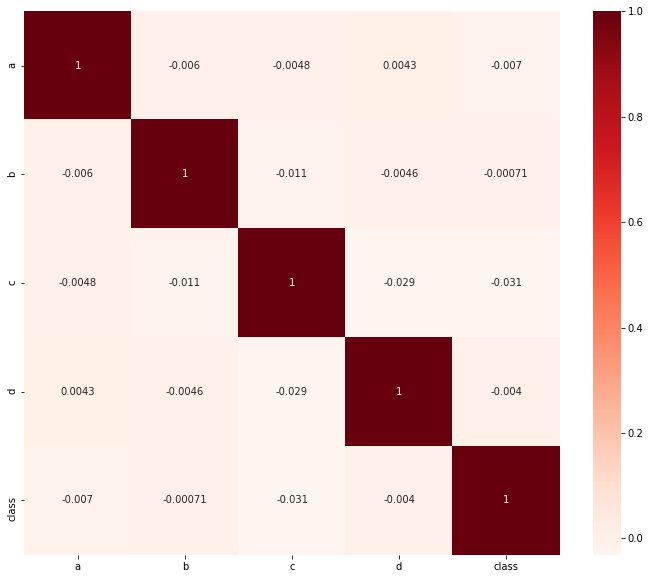

In [49]:
plt.figure(figsize=(12,10))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# checking correlation

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [51]:
clf = RandomForestClassifier(random_state=1)

kf = KFold(n_splits=5, random_state=1, shuffle=True)
param_grid = {'n_estimators': range(1, 102, 50),
             'max_depth': range(1, 6),
             'min_samples_leaf': range(1, 11, 5)}

grid = GridSearchCV(clf, param_grid, cv=kf, scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
      

In [52]:
res = (
    pd.DataFrame({
        "mean_test_score": grid.cv_results_["mean_test_score"],
        "mean_fit_time": grid.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid.cv_results_["params"]).add_prefix("param_"))
)
res

,mean_test_score,mean_fit_time,param_max_depth,param_min_samples_leaf,param_n_estimators
0,0.794934,0.005399,1,1,1
1,0.794934,0.090095,1,1,51
2,0.794934,0.158788,1,1,101
3,0.794934,0.003800,1,6,1
4,0.794934,0.085218,1,6,51
5,0.794934,0.159868,1,6,101
6,0.793811,0.004176,2,1,1
7,0.794934,0.097972,2,1,51
8,0.794934,0.185591,2,1,101
9,0.793811,0.004200,2,6,1


In [53]:
grid.best_score_

0.7949335039149487

In [54]:
grid.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 1}

In [55]:
clf = RandomForestClassifier(max_depth=1, min_samples_leaf=1, n_estimators=1, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

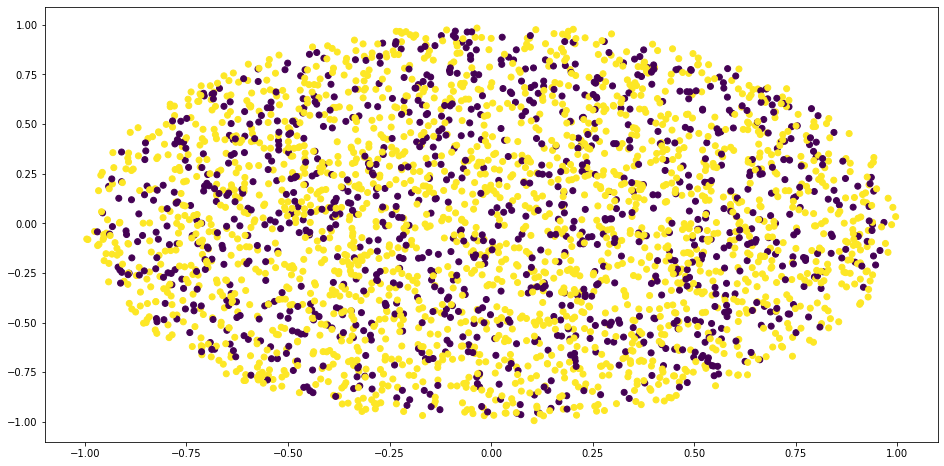

In [56]:
plt.scatter(X_train['a'], X_train['c'], c=y_train)
plt.show()
# so there is no pattern in our data
# hence our model has learnt constant prediction

In [57]:
y_pred = clf.predict(X_test)
np.savetxt("Y_test.csv", y_pred, delimiter=",")